In [1]:
import fpm_helper as fpm_helper
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
import json
import os

ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=11)

In [91]:
results_dir = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250127_na01_spectral_varying"
run_id ='oc4tkhk8' # 160 meas, spectral prior
results_dir = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250128_na01_spectral_prior"
run_id = 'ol4xoxv2'
# Load config file
import json
with open(f'{results_dir}/{run_id}/config_{run_id}.json', 'r') as f:
    config = json.load(f)


# Extract microscope parameters
micro_cfg = config['microscope']
mag = micro_cfg['magnification']
pix_size_camera = micro_cfg['pixel_size_camera']
na_obj = micro_cfg['na_objective']
spectral_obj = micro_cfg['spectral_obj']
# Create wavelength range
wv_cfg = micro_cfg['wavelength']
wv_range = np.arange(wv_cfg['start'], wv_cfg['end'], wv_cfg['step'])
# print(f"Using wavelength range: {wv_range} microns")

# Create FPM setup
fpm_setup = fpm_helper.FPM_setup(
    pix_size_camera=pix_size_camera,
    mag=mag,
    wv=wv_range,
    na_obj=na_obj,
    led_spacing=config['led_array']['spacing'],
    dist=config['led_array']['distance'],
    spectral_obj=spectral_obj
)

gt_object = fpm_setup.objstack.clone()

Using stock object data


/home/neerja/CODE/SpectralPtychographyProjectGitRepo/fpm_helper.py:344: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  wavelengths = torch.tensor(wavelengths, dtype=torch.float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2141229..2.8138497].


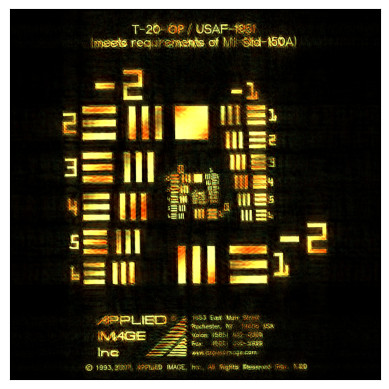

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88442254..2.7671819].


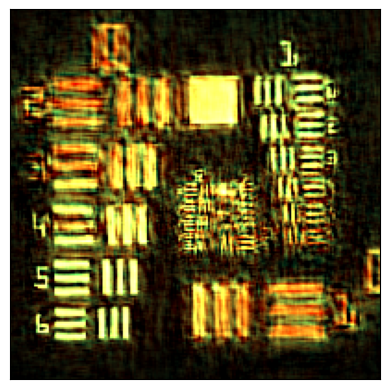

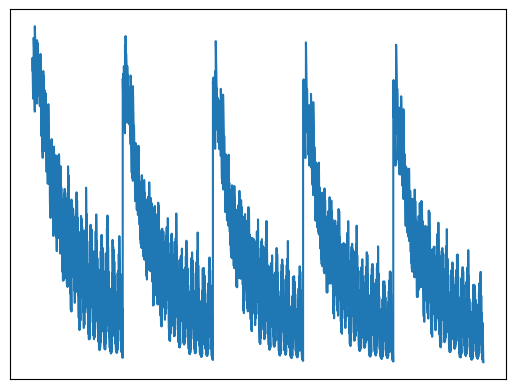

MSE at wavelength 500.0nm: 0.110799
SSIM value at wavelength 500.0nm: 0.7044
MSE at wavelength 550.0nm: 0.097187
SSIM value at wavelength 550.0nm: 0.7335
MSE at wavelength 600.0nm: 0.081976
SSIM value at wavelength 600.0nm: 0.7411
MSE at wavelength 650.0nm: 0.089450
SSIM value at wavelength 650.0nm: 0.7217
MSE at wavelength 700.0nm: 0.108468
SSIM value at wavelength 700.0nm: 0.7018
MSE at wavelength 750.0nm: 0.122318
SSIM value at wavelength 750.0nm: 0.7022
MSE at wavelength 800.0nm: 0.138330
SSIM value at wavelength 800.0nm: 0.6956
MSE at wavelength 850.0nm: 0.139904
SSIM value at wavelength 850.0nm: 0.6683
Avg MSE: 0.111054
Avg MS-SSIM: 0.7086


In [92]:

spectral_obj = np.load(f'{results_dir}/{run_id}/reconstructed_object.npy')
# Convert numpy array to torch tensor
spectral_obj = torch.from_numpy(spectral_obj)

wavelengths = fpm_setup.wv * 1e3 # convert to nm
rgb_recon = fpm_helper.spectral_obj_to_color(spectral_obj, wavelengths)

# plot the spectral object
plt.imshow(rgb_recon)
plt.xticks([])
plt.yticks([])
plt.show()

zoom_size = 200  # Adjust this value to change zoom level
center_y, center_x = rgb_recon.shape[0] // 2, rgb_recon.shape[1] // 2
zoom_recon = rgb_recon.detach().cpu().numpy()[
    center_y - zoom_size // 2:center_y + zoom_size // 2,
    center_x - zoom_size // 2:center_x + zoom_size // 2
]

plt.figure()
plt.imshow(zoom_recon)
plt.xticks([])
plt.yticks([])
plt.show()

# plot loss
loss = np.load(f'{results_dir}/{run_id}/loss_history.npy')
plt.figure()
plt.plot(np.log(loss))
# plt.xlabel('Iteration', fontsize=24)
plt.xticks([])
plt.yticks([])
# plt.ylabel('Loss', fontsize=24)
plt.show()

# print final MSE and MS-SSIM
ssim_vals = []
mse_list = []
for k in range(spectral_obj.shape[0]):
    curr_recon = spectral_obj[k,:,:]
    curr_recon = (curr_recon - curr_recon.min()) / (curr_recon.max() - curr_recon.min())
    curr_gt = gt_object[k,:,:]
    curr_gt = (curr_gt - curr_gt.min()) / (curr_gt.max() - curr_gt.min())
    mse = torch.nn.functional.mse_loss(curr_recon, curr_gt).item()
    mse_list.append(mse)
    print(f'MSE at wavelength {wv_range[k]*1e3:.1f}nm: {mse:.6f}')

    curr_recon = curr_recon.unsqueeze(0).unsqueeze(0)
    curr_gt = curr_gt.unsqueeze(0).unsqueeze(0)
    ssim_val = ssim(curr_recon, curr_gt)
    ssim_vals.append(ssim_val.item())
    print(f"SSIM value at wavelength {wv_range[k]*1e3:.1f}nm: {ssim_val.item():.4f}")

print(f"Avg MSE: {np.mean(mse_list):.6f}")
print(f"Avg MS-SSIM: {np.mean(ssim_vals):.4f}")


In [80]:
# compute sparsity metric on the spectral object
objest = spectral_obj
reg = torch.norm(torch.diff(torch.diff(objest, dim=0), dim=0), p=1)

In [81]:
print(reg)

tensor(356193.7188)


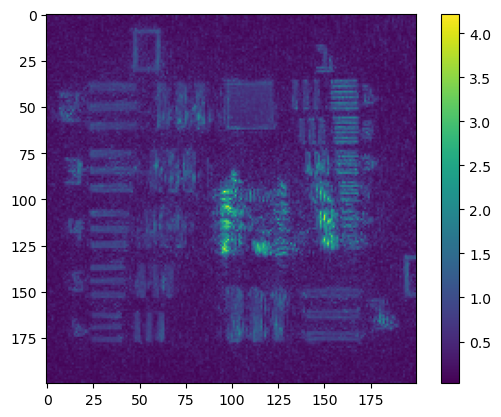

In [82]:
grad = torch.diff(torch.diff(objest, dim=0), dim=0)
grad_norm = torch.norm(grad, p=1, dim=0)
# Get center coordinates and zoom window size
center_y, center_x = grad_norm.shape[0]//2, grad_norm.shape[1]//2
window_size = 200
y_start = center_y - window_size//2
y_end = center_y + window_size//2
x_start = center_x - window_size//2 
x_end = center_x + window_size//2

# Create zoomed view
plt.figure()
plt.imshow(grad_norm[y_start:y_end, x_start:x_end])
plt.colorbar()
plt.show()

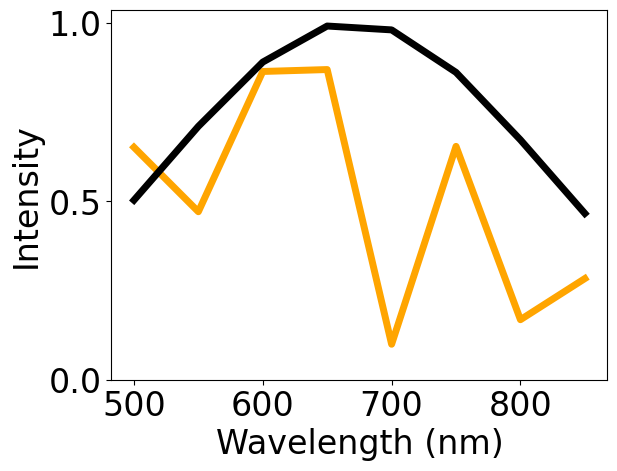

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7026304..2.723593].


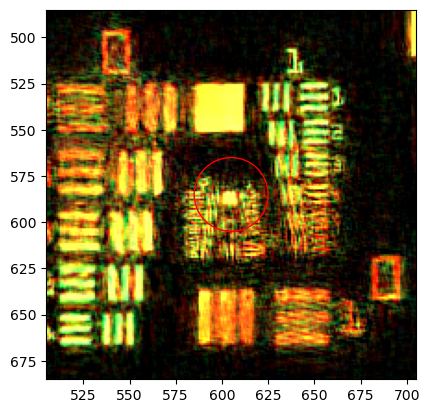

In [76]:
# plot the spectra at given pixel
pixel = (585,605)# y,x
plt.plot(wv_range*1e3, objest[:,pixel[0],pixel[1]],'orange', linewidth=5)
plt.plot(wv_range*1e3, gt_object[:,pixel[0],pixel[1]],'k', linewidth=5)
plt.xticks([500, 600, 700, 800],fontsize=24) 
plt.yticks([0, 0.5,1],fontsize=24)
plt.xlabel('Wavelength (nm)',fontsize=24)
plt.ylabel('Intensity',fontsize=24)
# plt.title('Spectral Object',fontsize=24)
# plt.legend(['Reconstructed', 'Ground Truth'],fontsize=16)
plt.show()

# draw circle around the pixel in the reconstructed image
plt.figure()
plt.imshow(rgb_recon)
circle = plt.Circle((pixel[1], pixel[0]), 20, color='r', fill=False)
plt.gca().add_patch(circle)
plt.xlim(pixel[1]-100, pixel[1]+100)
plt.ylim( pixel[0]+100, pixel[0]-100,)

plt.show()




## Slide 3 - sparsity priors

Using stock object data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66496193..2.8001678].


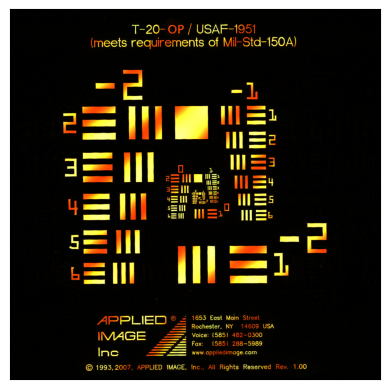

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66496193..2.5566719].


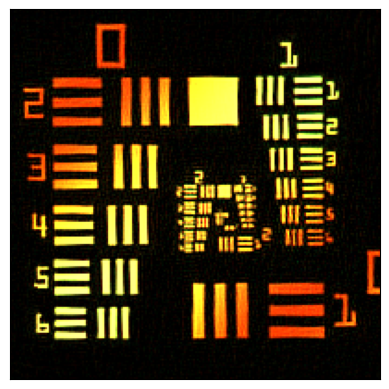

MSE at wavelength 500.0nm: 0.010031
SSIM value at wavelength 500.0nm: 0.8515
MSE at wavelength 550.0nm: 0.040871
SSIM value at wavelength 550.0nm: 0.8183
MSE at wavelength 600.0nm: 0.077983
SSIM value at wavelength 600.0nm: 0.8040
MSE at wavelength 650.0nm: 0.055927
SSIM value at wavelength 650.0nm: 0.8258
MSE at wavelength 700.0nm: 0.055663
SSIM value at wavelength 700.0nm: 0.8325
MSE at wavelength 750.0nm: 0.058900
SSIM value at wavelength 750.0nm: 0.8114
MSE at wavelength 800.0nm: 0.049902
SSIM value at wavelength 800.0nm: 0.7927
MSE at wavelength 850.0nm: 0.119744
SSIM value at wavelength 850.0nm: 0.7276
Avg MSE: 0.058628
Avg MS-SSIM: 0.8080


In [31]:


results_dir = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250127_na01_spectral_varying"
run_id = 'hqspwnkf' # no prior

results_dir = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250128_na01_spectral_prior"
run_id = 'qsshlw86' # XY prior
run_id = 'tc5aoid1' # Spectral + XY prior

results_dir = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250126_na01_spectral_varying"
run_id = 'ba4hlr4i' # 500 meas

# Load config file
import json
with open(f'{results_dir}/{run_id}/config_{run_id}.json', 'r') as f:
    config = json.load(f)


# Extract microscope parameters
micro_cfg = config['microscope']
mag = micro_cfg['magnification']
pix_size_camera = micro_cfg['pixel_size_camera']
na_obj = micro_cfg['na_objective']
spectral_obj = micro_cfg['spectral_obj']
# Create wavelength range
wv_cfg = micro_cfg['wavelength']
wv_range = np.arange(wv_cfg['start'], wv_cfg['end'], wv_cfg['step'])
# print(f"Using wavelength range: {wv_range} microns")

# Create FPM setup
fpm_setup = fpm_helper.FPM_setup(
    pix_size_camera=pix_size_camera,
    mag=mag,
    wv=wv_range,
    na_obj=na_obj,
    led_spacing=config['led_array']['spacing'],
    dist=config['led_array']['distance'],
    spectral_obj=spectral_obj
)

gt_object = fpm_setup.objstack.clone()

spectral_obj = np.load(f'{results_dir}/{run_id}/reconstructed_object.npy')
# Convert numpy array to torch tensor
spectral_obj = torch.from_numpy(spectral_obj)

wavelengths = fpm_setup.wv * 1e3 # convert to nm
rgb_recon = fpm_helper.spectral_obj_to_color(spectral_obj, wavelengths)

# plot the spectral object
plt.imshow(rgb_recon)
plt.xticks([])
plt.yticks([])
plt.show()

zoom_size = 200  # Adjust this value to change zoom level
center_y, center_x = rgb_recon.shape[0] // 2, rgb_recon.shape[1] // 2
zoom_recon = rgb_recon.detach().cpu().numpy()[
    center_y - zoom_size // 2:center_y + zoom_size // 2,
    center_x - zoom_size // 2:center_x + zoom_size // 2
]

plt.figure()
plt.imshow(zoom_recon)
plt.xticks([])
plt.yticks([])
plt.show()

# print final MSE and MS-SSIM
ssim_vals = []
mse_list = []
for k in range(spectral_obj.shape[0]):
    curr_recon = spectral_obj[k,:,:]
    curr_recon = (curr_recon - curr_recon.min()) / (curr_recon.max() - curr_recon.min())
    curr_gt = gt_object[k,:,:]
    curr_gt = (curr_gt - curr_gt.min()) / (curr_gt.max() - curr_gt.min())
    mse = torch.nn.functional.mse_loss(curr_recon, curr_gt).item()
    mse_list.append(mse)
    print(f'MSE at wavelength {wv_range[k]*1e3:.1f}nm: {mse:.6f}')

    curr_recon = curr_recon.unsqueeze(0).unsqueeze(0)
    curr_gt = curr_gt.unsqueeze(0).unsqueeze(0)
    ssim_val = ssim(curr_recon, curr_gt)
    ssim_vals.append(ssim_val.item())
    print(f"SSIM value at wavelength {wv_range[k]*1e3:.1f}nm: {ssim_val.item():.4f}")

print(f"Avg MSE: {np.mean(mse_list):.6f}")
print(f"Avg MS-SSIM: {np.mean(ssim_vals):.4f}")



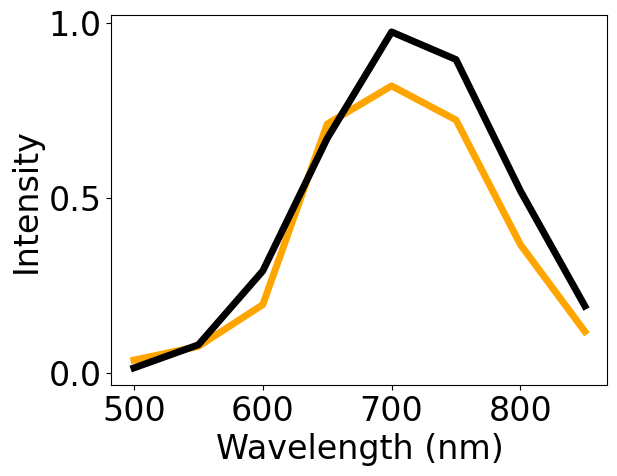

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66496193..2.8001678].


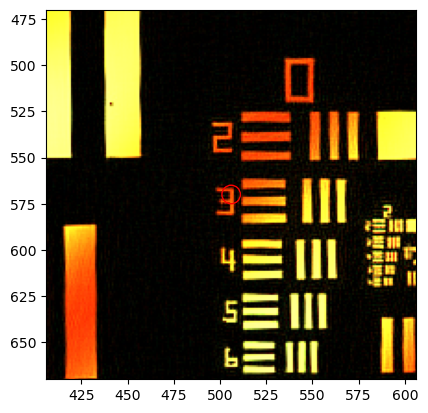

In [39]:
# plot the spectra at given pixel
objest = spectral_obj
pixel = (585,605)# y,x,  yellow square
pixel = (570,506)# y,x,  red 3
plt.plot(wv_range*1e3, objest[:,pixel[0],pixel[1]],'orange', linewidth=5)
plt.plot(wv_range*1e3, gt_object[:,pixel[0],pixel[1]],'k', linewidth=5)
plt.xticks([500, 600, 700, 800],fontsize=24) 
plt.yticks([0, 0.5,1],fontsize=24)
plt.xlabel('Wavelength (nm)',fontsize=24)
plt.ylabel('Intensity',fontsize=24)
# plt.title('Spectral Object',fontsize=24)
# plt.legend(['Reconstructed', 'Ground Truth'],fontsize=16)
plt.show()

# draw circle around the pixel in the reconstructed image
plt.figure()
plt.imshow(rgb_recon)
circle = plt.Circle((pixel[1], pixel[0]), 5, color='r', fill=False)
plt.gca().add_patch(circle)
plt.xlim(pixel[1]-100, pixel[1]+100)
plt.ylim( pixel[0]+100, pixel[0]-100,)

plt.show()




/tmp/ipykernel_2361057/3934204476.py:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(wv_range*1e3, gt_object[:,pixel[0],pixel[1]],'k', linewidth=5, color = 'black')


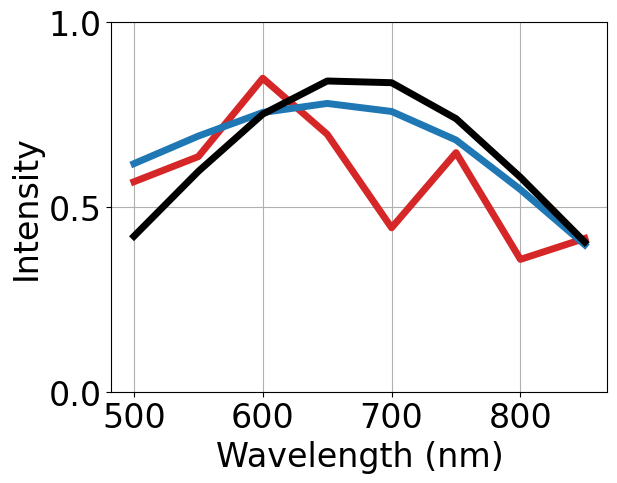

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66496193..2.8001678].


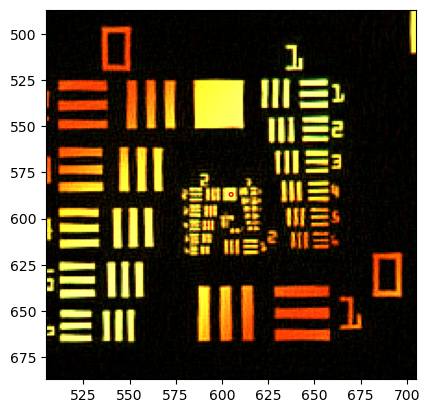

In [61]:
# plot spectra for different runs

# no priors
results_dir_1 = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250126_na01_spectral_varying"
run_id_1 = 'ba4hlr4i'
results_dir_2 = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250127_na01_spectral_varying"
run_id_2 = 'hqspwnkf'

results_dir_3 = "/home/neerja/CODE/SpectralPtychographyProjectGitRepo/results/20250128_na01_spectral_prior"
run_id_3 = 'qsshlw86'
run_id_4 = 'tc5aoid1'

labels = ['500 meas - no prior', '160 meas - no prior', '160 meas - Spatial Prior', '160 meas - Spectral + Spatial Prior']

pixel = (587,605)# y,x,  yellow square
# pixel = (573,506)# y,x,  red 3
pix_win = 1

colors = ['tab:red', 'tab:blue', 'tab:black']

for i, run_id in enumerate([run_id_2, run_id_4]):
    if run_id == run_id_1:
        results_dir = results_dir_1
    elif run_id == run_id_2:
        results_dir = results_dir_2
    else:
        results_dir = results_dir_3
    # load the spectral object
    spectral_obj = np.load(f'{results_dir}/{run_id}/reconstructed_object.npy')
    # Convert numpy array to torch tensor
    spectral_obj = torch.from_numpy(spectral_obj)

    # plot the pixel spectra
    # compute the average spectra for surrounding pixels
    avg_spectra = spectral_obj[:, pixel[0]-pix_win:pixel[0]+pix_win+1, pixel[1]-pix_win:pixel[1]+pix_win+1].mean(dim=(1, 2))
    plt.plot(wv_range*1e3, avg_spectra, linewidth=5, color = colors[i])
plt.plot(wv_range*1e3, gt_object[:,pixel[0],pixel[1]],'k', linewidth=5, color = 'black')
plt.xticks([500, 600, 700, 800],fontsize=24) 
plt.yticks([0, 0.5,1],fontsize=24)
plt.xlabel('Wavelength (nm)',fontsize=24)
plt.ylabel('Intensity',fontsize=24)
# plt.legend(labels, fontsize=24, loc='lower center', bbox_to_anchor=(0.5, -0.3))
plt.grid(True)
plt.show()


# draw circle around the pixel in the reconstructed image
plt.figure()
plt.imshow(rgb_recon)
circle = plt.Circle((pixel[1], pixel[0]), pix_win, color='r', fill=False)
plt.gca().add_patch(circle)
plt.xlim(pixel[1]-100, pixel[1]+100)
plt.ylim( pixel[0]+100, pixel[0]-100,)
plt.show()
